In [4]:
# Import libraries
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine

# Download stock data (e.g., Apple)
df = yf.download("AAPL", start="2015-01-01", end="2025-01-01")

# Inspect data
print(df.head())

# Feature engineering
df['Return'] = df['Close'].pct_change()  # daily returns
df['MA20'] = df['Close'].rolling(20).mean()  # 20-day moving average
df['MA50'] = df['Close'].rolling(50).mean()  # 50-day moving average

# Drop missing values created by rolling calculations
df = df.dropna()

# Reset index to have 'Date' as a column
df.reset_index(inplace=True)


C:\Users\vivsz\AppData\Local\Temp\ipykernel_40940\1010051841.py:12: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-01-01", end="2025-01-01")
[*********************100%***********************]  1 of 1 completed

Price           Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                             
2015-01-02  24.261047  24.729270  23.821672  24.718174  212818400
2015-01-05  23.577572  24.110148  23.391171  24.030261  257142000
2015-01-06  23.579798  23.839428  23.218089  23.641931  263188400
2015-01-07  23.910435  24.010292  23.677432  23.788385  160423600
2015-01-08  24.829124  24.886821  24.121242  24.238854  237458000


In [3]:
!pip install yfinance


[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# MySQL connection (replace with your credentials)
user = "root"
password = "password%40123"  # use URL-encoded password if needed
host = "localhost"
database = "stock_db"

# Create engine
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:3306/{database}")

# Create database if not exists
with engine.connect() as conn:
    conn.execute("CREATE DATABASE IF NOT EXISTS stock_db;")

# Push cleaned data to MySQL
df.to_sql("aapl_stock", engine, if_exists="replace", index=False)
print("✅ Data loaded successfully into MySQL table 'aapl_stock'")


ProgrammingError: (mysql.connector.errors.ProgrammingError) 1049 (42000): Unknown database 'stock_db'
(Background on this error at: https://sqlalche.me/e/14/f405)

In [7]:
from sqlalchemy import create_engine

user = "root"
password = "password%40123"  # encode special chars
host = "localhost"
database = "stock_db"

# Connect to MySQL server without specifying a database
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:3306/")


In [8]:
with engine.connect() as conn:
    conn.execute(f"CREATE DATABASE IF NOT EXISTS {database};")
    print(f"✅ Database '{database}' created (if it didn't exist)")


✅ Database 'stock_db' created (if it didn't exist)


In [9]:
# Now connect specifying the database
engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:3306/{database}")


In [10]:
df.to_sql("aapl_stock", engine, if_exists="replace", index=False)
print("✅ Data loaded successfully into MySQL table 'aapl_stock'")


✅ Data loaded successfully into MySQL table 'aapl_stock'


In [11]:
# If df has multi-level columns (from yfinance or after some calculations)
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Reset index so Date is a proper column
df.reset_index(inplace=True)

# Now push to MySQL
df.to_sql("aapl_stock", engine, if_exists="replace", index=False)


2467

In [12]:
import pandas as pd
from sqlalchemy import create_engine

user = "root"
password = "password%40123"
host = "localhost"
database = "stock_db"

engine = create_engine(f"mysql+mysqlconnector://{user}:{password}@{host}:3306/{database}")

query = "SELECT Date, Close, Volume, MA20, MA50, `Return` FROM aapl_stock;"
df = pd.read_sql(query, engine)

df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')


In [14]:
print(df.columns)  # check exact column names first

# Ensure no hidden spaces in column names
df.columns = df.columns.str.strip()

# Create UpDown target column
df['UpDown'] = (df['Return'].shift(-1) > 0).astype(int)

# Drop last row (since it has no next-day return)
df = df.dropna(subset=['UpDown'])


Index(['Date', 'Close', 'Volume', 'MA20', 'MA50', 'Return'], dtype='object')


In [15]:
print(df[['Date','Return','UpDown']].head(10))


        Date    Return  UpDown
0 2015-03-16  0.011004       1
1 2015-03-17  0.016727       1
2 2015-03-18  0.011256       0
3 2015-03-19 -0.007550       0
4 2015-03-20 -0.012549       1
5 2015-03-23  0.010405       0
6 2015-03-24 -0.004088       0
7 2015-03-25 -0.026127       1
8 2015-03-26  0.006970       0
9 2015-03-27 -0.007968       1


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Features (X) and target (y)
X = df[['Close', 'Volume', 'MA20', 'MA50', 'Return']]
y = df['UpDown']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy: 0.451417004048583
              precision    recall  f1-score   support

           0       0.44      0.91      0.59       218
           1       0.56      0.09      0.16       276

    accuracy                           0.45       494
   macro avg       0.50      0.50      0.37       494
weighted avg       0.50      0.45      0.35       494



In [17]:
model = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)


In [18]:
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.46356275303643724
              precision    recall  f1-score   support

           0       0.45      0.88      0.59       218
           1       0.59      0.13      0.22       276

    accuracy                           0.46       494
   macro avg       0.52      0.51      0.40       494
weighted avg       0.52      0.46      0.38       494



In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Load dataset (already cleaned with MA20, MA50, Return)
df = pd.read_csv("AAPL_Features.csv")

# Add label (Up = 1 if Return > 0, else 0)
df["UpDown"] = (df["Return"] > 0).astype(int)

# Features & target
X = df[["Close", "Volume", "MA20", "MA50", "Return"]]
y = df["UpDown"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)

# Scale features for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# ---------------- Logistic Regression ----------------
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# ---------------- XGBoost ----------------
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Results:
Accuracy: 0.9946018893387314
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       347
           1       0.99      1.00      0.99       394

    accuracy                           0.99       741
   macro avg       0.99      0.99      0.99       741
weighted avg       0.99      0.99      0.99       741

XGBoost Results:
Accuracy: 0.9959514170040485
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       347
           1       0.99      1.00      1.00       394

    accuracy                           1.00       741
   macro avg       1.00      1.00      1.00       741
weighted avg       1.00      1.00      1.00       741



In [20]:
# Save the feature dataset
df.to_csv("AAPL_Features.csv", index=False)
print("✅ File saved as AAPL_Features.csv")


✅ File saved as AAPL_Features.csv


In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Load dataset
df = pd.read_csv("AAPL_Features.csv")

# Create target variable
df["UpDown"] = (df["Return"] > 0).astype(int)

# IMPORTANT: Drop "Return" from features to prevent leakage
X = df[["Close", "Volume", "MA20", "MA50"]]
y = df["UpDown"]

# Time-based split (no shuffle!)
split = int(len(df) * 0.7)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Results:
Accuracy: 0.6072874493927125
              precision    recall  f1-score   support

           0       0.58      0.60      0.59       347
           1       0.64      0.61      0.62       394

    accuracy                           0.61       741
   macro avg       0.61      0.61      0.61       741
weighted avg       0.61      0.61      0.61       741

XGBoost Results:
Accuracy: 0.5384615384615384
              precision    recall  f1-score   support

           0       0.52      0.19      0.28       347
           1       0.54      0.85      0.66       394

    accuracy                           0.54       741
   macro avg       0.53      0.52      0.47       741
weighted avg       0.53      0.54      0.48       741



In [23]:
import pandas as pd
import numpy as np

# Load stock data
df = pd.read_csv("AAPL_Features.csv")

# RSI (Relative Strength Index, 14-day)
window_length = 14
delta = df["Close"].diff()
gain = (delta.where(delta > 0, 0)).rolling(window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window_length).mean()
rs = gain / loss
df["RSI"] = 100 - (100 / (1 + rs))

# Bollinger Bands (20-day)
df["BB_Middle"] = df["Close"].rolling(20).mean()
df["BB_Upper"] = df["BB_Middle"] + 2 * df["Close"].rolling(20).std()
df["BB_Lower"] = df["BB_Middle"] - 2 * df["Close"].rolling(20).std()

# MACD (12-day EMA - 26-day EMA)
exp1 = df["Close"].ewm(span=12, adjust=False).mean()
exp2 = df["Close"].ewm(span=26, adjust=False).mean()
df["MACD"] = exp1 - exp2
df["Signal_Line"] = df["MACD"].ewm(span=9, adjust=False).mean()

# Drop rows with NaN due to rolling calculations
df = df.dropna()

# Save enhanced dataset
df.to_csv("AAPL_Indicators.csv", index=False)
print("✅ Indicators added and saved as AAPL_Indicators.csv")


✅ Indicators added and saved as AAPL_Indicators.csv


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# Reload dataset with indicators
df = pd.read_csv("AAPL_Indicators.csv")

# Target variable
df["UpDown"] = (df["Return"] > 0).astype(int)

# Features (no leakage!)
X = df[["Close", "Volume", "MA20", "MA50", "RSI", "BB_Upper", "BB_Lower", "MACD", "Signal_Line"]]
y = df["UpDown"]

# Time-based split
split = int(len(df) * 0.7)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Scale for Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Logistic Regression
log_reg = LogisticRegression(max_iter=1000, class_weight="balanced")
log_reg.fit(X_train_scaled, y_train)
y_pred_log = log_reg.predict(X_test_scaled)

print("Logistic Regression Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

# XGBoost
xgb = XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_test)

print("XGBoost Results:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))


Logistic Regression Results:
Accuracy: 0.726530612244898
              precision    recall  f1-score   support

           0       0.75      0.62      0.68       341
           1       0.71      0.82      0.76       394

    accuracy                           0.73       735
   macro avg       0.73      0.72      0.72       735
weighted avg       0.73      0.73      0.72       735

XGBoost Results:
Accuracy: 0.563265306122449
              precision    recall  f1-score   support

           0       0.54      0.45      0.49       341
           1       0.58      0.66      0.62       394

    accuracy                           0.56       735
   macro avg       0.56      0.56      0.55       735
weighted avg       0.56      0.56      0.56       735



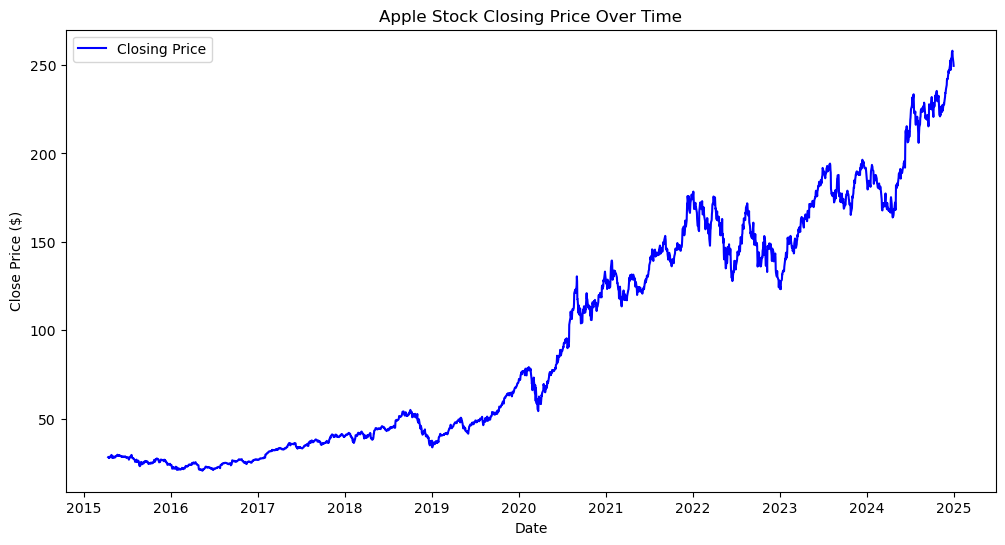

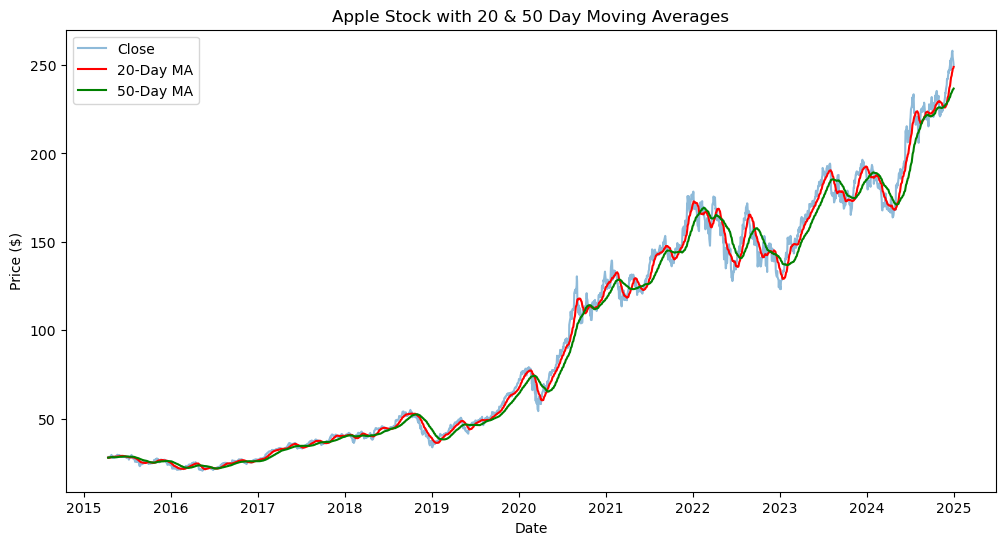

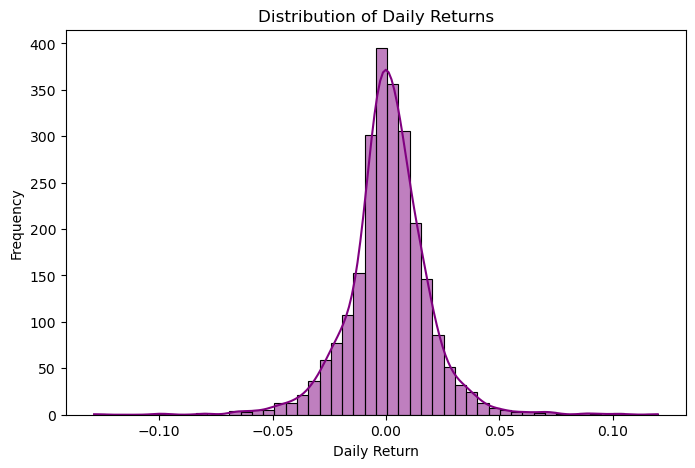

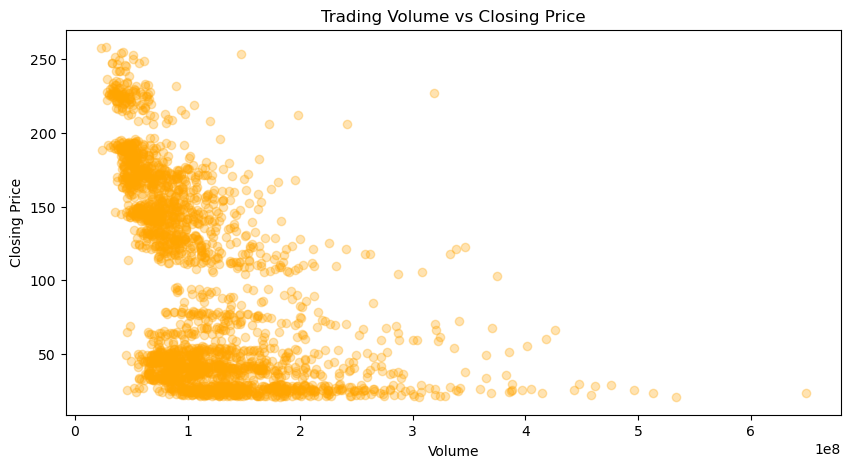

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# -----------------------------
# 1. Closing Price over Time
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Closing Price", color="blue")
plt.title("Apple Stock Closing Price Over Time")
plt.xlabel("Date")
plt.ylabel("Close Price ($)")
plt.legend()
plt.show()

# -----------------------------
# 2. Moving Averages
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label="Close", alpha=0.5)
plt.plot(df['Date'], df['MA20'], label="20-Day MA", color="red")
plt.plot(df['Date'], df['MA50'], label="50-Day MA", color="green")
plt.title("Apple Stock with 20 & 50 Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.show()

# -----------------------------
# 3. Daily Returns Distribution
# -----------------------------
plt.figure(figsize=(8,5))
sns.histplot(df['Return'], bins=50, kde=True, color="purple")
plt.title("Distribution of Daily Returns")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.show()

# -----------------------------
# 4. Volume vs Price
# -----------------------------
plt.figure(figsize=(10,5))
plt.scatter(df['Volume'], df['Close'], alpha=0.3, color="orange")
plt.title("Trading Volume vs Closing Price")
plt.xlabel("Volume")
plt.ylabel("Closing Price")
plt.show()
